
<div align="center">
<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="20%" />

### **SPAM detector Project Summary**
- [Preprocessing](#preprocessing)
- [EDA](#eda)
- [Model and Training](#model-and-training)
- [Evaluate Performancee](#evaluate-performance)
</div>

In [ ]:
!pip install spacy -q
!pip install wordcloud -q
!python -m spacy download en_core_web_md -q

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-14 16:59:27.753352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 16:59:29.577916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-14 16:59:29.578054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open share

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import spacy
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
dataset = pd.read_csv('https://at-t-spam-detector.s3.eu-west-3.amazonaws.com/spam.csv', encoding="ISO-8859-1")

In [ ]:
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
useless_cols = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
dataset = dataset.drop(useless_cols, axis=1)

In [ ]:
dataset.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
dataset.isna().sum()

v1    0
v2    0
dtype: int64

In [ ]:
dataset.shape

(5572, 2)

In [ ]:
dataset['v2'].nunique()

5169

In [ ]:
dataset['v2'].drop_duplicates(inplace=True)

# Preprocessing

> **ham** = **0**

> **spam** = **1**

In [ ]:
dataset['label'] = dataset['v1'].map({'ham': 0, 'spam': 1})

In [ ]:
# Import Spacy and english initialisation
import spacy

nlp = spacy.load('en_core_web_md')

In [ ]:
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
# Remove all non alphanumeric characters except whitespaces
dataset["v3"] = dataset["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
dataset["v3"] = dataset["v3"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove numbers
dataset["v3"] = dataset["v3"].apply(lambda x: re.sub(r"\d+", "", x))
# remove websites
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
dataset["v3"] = dataset["v3"].apply(lambda x: web_address .sub("", x))
# remove user
user = re.compile(r"(?i)@[a-z0-9_]+")
dataset["v3"] = dataset["v3"].apply(lambda x: user.sub("", x))
# remove whitespaces
whitespace = re.compile(r"\s+")
dataset["v3"] = dataset["v3"].apply(lambda x: whitespace.sub(" ", x))
# remove stop words and replace everyword with their lemma
dataset["v3"]= dataset["v3"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

##### Before

In [ ]:
dataset.iloc[0]['v2']

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

##### After

In [ ]:
dataset.iloc[0]['v3']

'go until jurong point crazy available only in bugis n great world e buffet cine there get amore wat'

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    oov_token="out_of_vocab") # instanciate the tokenizer
# num_words indicates the number of words to keep in the tokenization
# keeps only the most common words

tokenizer.fit_on_texts(dataset["v3"]) # fit the tokenizer on the texts
# in this step the tokenizer will list all unique tokens in the text
# and associate them with a specific integer.

# This step will effectively transform the texts into sequences of indices
dataset["v3_encoded"] = tokenizer.texts_to_sequences(dataset["v3"])

In [ ]:
# this will show you the lookup table for the words and indices
tokenizer.index_word

{1: 'out_of_vocab',
 2: 'be',
 3: 'to',
 4: 'you',
 5: 'the',
 6: 'u',
 7: 'not',
 8: 'do',
 9: 'and',
 10: 'in',
 11: 'have',
 12: 'my',
 13: 'for',
 14: 'your',
 15: 'get',
 16: 'call',
 17: 'it',
 18: 'of',
 19: 'go',
 20: 'that',
 21: 'can',
 22: 'm',
 23: 'now',
 24: 'so',
 25: 'will',
 26: 'but',
 27: 'we',
 28: 'at',
 29: 'ur',
 30: 'with',
 31: 'if',
 32: 'just',
 33: 'no',
 34: 'this',
 35: 's',
 36: 'he',
 37: 'come',
 38: 'how',
 39: 'its',
 40: 'up',
 41: 'what',
 42: 'when',
 43: 'know',
 44: 'from',
 45: 'free',
 46: 'ok',
 47: 'ltgt',
 48: 'good',
 49: 'å',
 50: 'out',
 51: 'all',
 52: 'day',
 53: 'like',
 54: 'want',
 55: 'ill',
 56: 'then',
 57: 'time',
 58: 'there',
 59: 'love',
 60: 'say',
 61: 'only',
 62: 'text',
 63: 'they',
 64: 'she',
 65: 'tell',
 66: 'see',
 67: 'send',
 68: 'think',
 69: 'need',
 70: 'take',
 71: 'well',
 72: 'one',
 73: 'make',
 74: 'by',
 75: 'today',
 76: 'about',
 77: 'txt',
 78: 'home',
 79: 'r',
 80: 'lor',
 81: 'reply',
 82: 'd',
 83: 

In [ ]:
tokenizer.num_words

1000

In [ ]:
dataset['v3_encoded'].map(len).max()

164

In [ ]:
dataset.head()

,v1,v2,label,v3,v3_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...,"[19, 402, 1, 334, 562, 583, 61, 10, 1, 89, 109..."
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[46, 295, 584, 403, 6, 1]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in wkly comp to win fa cup final tk...,"[45, 417, 10, 650, 779, 3, 86, 1, 891, 537, 1,..."
3,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say,"[6, 222, 60, 24, 251, 1, 6, 149, 138, 56, 60]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah do not think he go to usf he live around h...,"[824, 8, 7, 68, 36, 19, 3, 780, 36, 228, 198, ..."


In [ ]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset["v3_encoded"], padding="post")

In [ ]:
train_pad

array([[ 19, 402,   1, ...,   0,   0,   0],
       [ 46, 295, 584, ...,   0,   0,   0],
       [ 45, 417,  10, ...,   0,   0,   0],
       ...,
       [  1,   2,  10, ...,   0,   0,   0],
       [  5, 204,   8, ...,   0,   0,   0],
       [  1,  39, 439, ...,   0,   0,   0]], dtype=int32)

In [ ]:
train_pad.shape

(5572, 164)

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split

Y = dataset['label'].values

X_train,X_test, y_train, y_test = train_test_split(train_pad, Y, stratify=Y, test_size=0.3, random_state=42)

In [ ]:
# We'll use this to form a tensorflow dataset containing on the one hand
# the encoded texts and the labels.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,  y_test))

In [ ]:
# We then organize the dataset per batch
train_ds = train_ds.shuffle(len(train_ds)).batch(64)
test_ds = test_ds.shuffle(len(test_ds)).batch(64)

In [ ]:
# Look at a batch of data
next(iter(train_ds))

(<tf.Tensor: shape=(64, 164), dtype=int32, numpy=
 array([[ 21,   4, 440, ...,   0,   0,   0],
        [  8,   7,  43, ...,   0,   0,   0],
        [338,  14, 555, ...,   0,   0,   0],
        ...,
        [101,   1, 878, ...,   0,   0,   0],
        [  4,  43, 453, ...,   0,   0,   0],
        [  1, 322, 649, ...,   0,   0,   0]], dtype=int32)>,
 <tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>)

# EDA

#### Class distribution

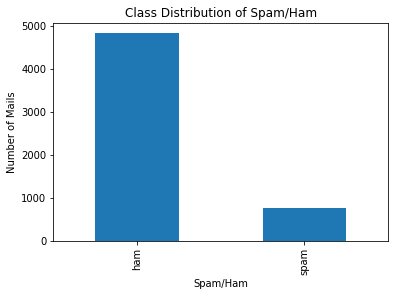

In [ ]:
# Create a bar plot of the class distribution
class_counts = dataset['v1'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Spam/Ham')
plt.xlabel('Spam/Ham')
plt.ylabel('Number of Mails')
plt.show()

#### Visualizing most commonly used words

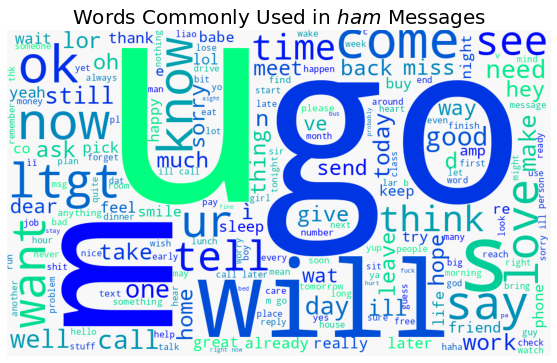

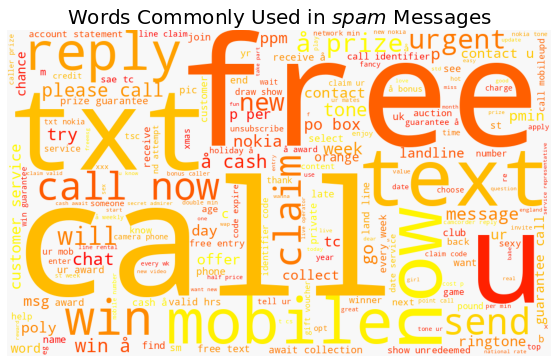

In [ ]:
from wordcloud import WordCloud

for label, cmap in zip(["ham", "spam"], ["winter", "autumn"]):
    text = dataset.query("v1 == @label")["v3"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
    plt.show()

# Model and Training

#### **Sequential model**
A **Sequential model** is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
The Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index.

**Global Average Pooling** is a pooling operation designed to replace fully connected layers in classical CNNs. The idea is to generate one feature map for each corresponding category of the classification task in the last mlpconv layer. Instead of adding fully connected layers on top of the feature maps, we take the average of each feature map.

**A dense layer** is a layer that is deeply connected with its preceding layer which means the neurons of the layer are connected to every neuron of its preceding layer. This layer is the most commonly used layer in artificial neural network networks.

In [ ]:
vocab_size = tokenizer.num_words
input_length = dataset['v3_encoded'].map(len).max()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=input_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
    ])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 164, 64)           64000     
                                                                 
 global_average_pooling1d_14  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_43 (Dense)            (None, 64)                4160      
                                                                 
 dense_44 (Dense)            (None, 32)                2080      
                                                                 
 dense_45 (Dense)            (None, 1)                 33        
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________

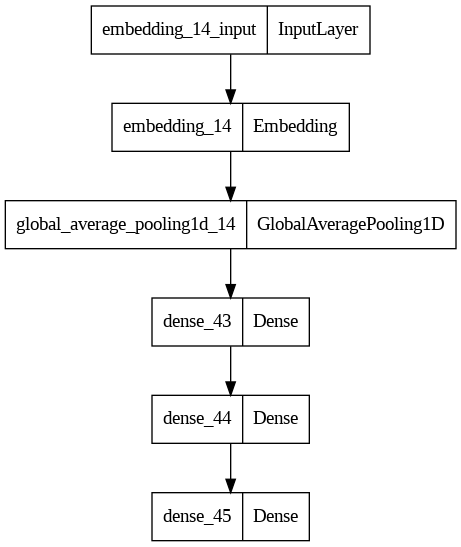

In [ ]:
# display the model
tf.keras.utils.plot_model(model)

In [ ]:
# define the tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
# define the early stopping callback
# patience parameter is the number of epochs to wait before stopping training if the monitored metric does not improve.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model.fit(train_ds, validation_data=test_ds, epochs=100, callbacks=[tensorboard_callback, early_stop])

Epoch 1/100
61/61 [==============================] - 2s 10ms/step - loss: 0.5207 - binary_accuracy: 0.8544 - val_loss: 0.3821 - val_binary_accuracy: 0.8660
Epoch 2/100
61/61 [==============================] - 1s 8ms/step - loss: 0.3760 - binary_accuracy: 0.8659 - val_loss: 0.3690 - val_binary_accuracy: 0.8660
Epoch 3/100
61/61 [==============================] - 1s 8ms/step - loss: 0.3595 - binary_accuracy: 0.8659 - val_loss: 0.3461 - val_binary_accuracy: 0.8660
Epoch 4/100
61/61 [==============================] - 0s 7ms/step - loss: 0.3198 - binary_accuracy: 0.8659 - val_loss: 0.2817 - val_binary_accuracy: 0.8660
Epoch 5/100
61/61 [==============================] - 1s 8ms/step - loss: 0.2114 - binary_accuracy: 0.9046 - val_loss: 0.1500 - val_binary_accuracy: 0.9522
Epoch 6/100
61/61 [==============================] - 1s 9ms/step - loss: 0.1021 - binary_accuracy: 0.9679 - val_loss: 0.0825 - val_binary_accuracy: 0.9725
Epoch 7/100
61/61 [==============================] - 1s 9ms/step - lo

# Evaluate Performance

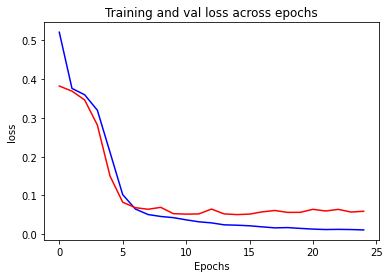

In [ ]:
# Visualization of the training process for the loss
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title('Training and val loss across epochs')
plt.show()

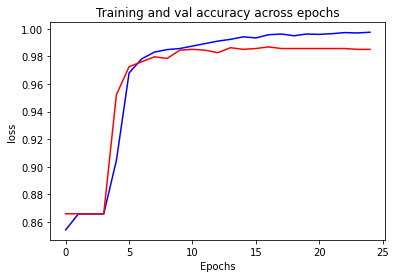

In [ ]:
# Visualization of the training process for the accuracy
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title('Training and val accuracy across epochs')
plt.show()

In [ ]:
model.evaluate(test_ds)

27/27 [==============================] - 0s 3ms/step - loss: 0.0592 - binary_accuracy: 0.9850


[0.059239570051431656, 0.9850478172302246]

### Performance Report

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test,  y_test))
test_ds = test_ds.shuffle(len(test_ds)).batch(X_test.shape[0])

test_inputs, test_labels = next(iter(test_ds))

In [ ]:
#Predicting the test data
preds_proba = model.predict(test_inputs)

53/53 [==============================] - 0s 4ms/step


In [ ]:
preds_proba

array([[1.1349266e-03],
       [5.4297547e-05],
       [4.5216152e-06],
       ...,
       [5.4986798e-03],
       [1.7694623e-03],
       [9.9994791e-01]], dtype=float32)

In [ ]:
preds_proba = preds_proba.squeeze()

In [ ]:
pd.Series(test_labels.numpy()).value_counts()

0    1448
1     224
dtype: int64

In [ ]:
display_names = ['0 => ham', '1 => spam']

In [ ]:
# The preds array is obtained by thresholding the predicted probabilities at 0.5 to obtain binary predictions
preds = (preds_proba >= 0.5).astype(int)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [ ]:
print(classification_report(test_labels, preds, target_names=display_names))

              precision    recall  f1-score   support

    0 => ham       0.99      1.00      0.99      1448
   1 => spam       0.98      0.91      0.94       224

    accuracy                           0.99      1672
   macro avg       0.98      0.95      0.97      1672
weighted avg       0.98      0.99      0.98      1672



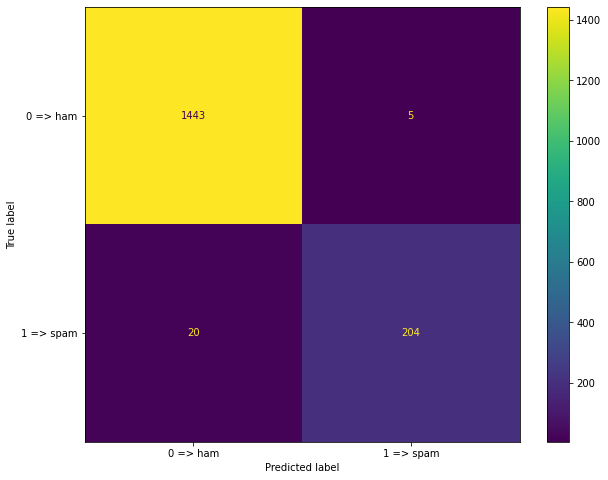

In [ ]:
conf_arr = confusion_matrix(test_labels, preds)
cmp = ConfusionMatrixDisplay(conf_arr, display_labels=display_names)
fig, ax = plt.subplots(figsize=(10, 8))
cmp.plot(ax=ax)

## Conclusion:

> The overall performance of the model is very good. by having more data on spam to deal with imbalanced data, we can get even better predictions.

We try the following methods to improve score but it didn't help :  
- change Class Weights to handle imbalanced data during training.
- Regularization, by adding Dropout layers.